In [ ]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from src.model import model
import pandas as pd
import os
import joblib
#load model
seed = 42
my_model = model(seed)
#my_model.classifier = joblib.load("src/models/hog_prob.pkl")
my_model.classifier = joblib.load("src/models/hog_second_pass.pkl")
print(my_model.classifier)


SVC(C=10, class_weight='balanced', kernel='linear', max_iter=10000,
    probability=True, random_state=42, verbose=0)


In [2]:
from detection import detection_images_in_folder
import warnings

warnings.filterwarnings("ignore", message="Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present.")


#image_path = "dataset/train/images"
#image_path = "dataset/val/images"
image_path = "dataset/test"

## detect the images in val  it will sortir an detections.csv
detection_images_in_folder(image_path, my_model, 'detections.csv')

Detecting traffic signs: 100%|██████████| 89/89 [02:29<00:00,  1.68s/it] 


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from detection import build_detection_validation
label_path = "dataset/train/labels"
build_detection_validation(label_path)


# Load the data
validations = pd.read_csv('validations.csv', header=None)
detections = pd.read_csv('detections.csv', header=None)

# Filter out the 'ff' labels
validations = validations[validations.iloc[:, 5] != 'ff']
detections = detections[detections.iloc[:, 6] != 'ff']

# Function to check if a value can be converted to float
def is_float(value):
    try:
        float(value)
        return True
    except ValueError:
        print(f"{value} rejected")
        return False

# Ensure the data types are correct and filter out non-numeric rows
validations = validations[validations.iloc[:, 1:5].map(is_float).all(axis=1)]
detections = detections[detections.iloc[:, 1:5].map(is_float).all(axis=1)]

validations.iloc[:, 1:5] = validations.iloc[:, 1:5].astype(float)
detections.iloc[:, 1:5] = detections.iloc[:, 1:5].astype(float)
detections.iloc[:, 5] = detections.iloc[:, 5].astype(float)

'0023.csv'empty
'0052.csv'empty
'0416.csv'empty
'0408.csv'empty
'0728.csv'empty
'0041.csv'empty
'0093.csv'empty
'0109.csv'empty
'0370.csv'empty
'0797.csv'empty
'0521.csv'empty
'0169.csv'empty
'0028.csv'empty
'0464.csv'empty
'0824.csv'empty
'0542.csv'empty
'0596.csv'empty
'0393.csv'empty
'0456.csv'empty
'0363.csv'empty
'0600.csv'empty
'0512.csv'empty
'0078.csv'empty
'0549.csv'empty
'0538.csv'empty
'0644.csv'empty
'0220.csv'empty
'0190.csv'empty
'0256.csv'empty
'0162.csv'empty
'0305.csv'empty
'0489.csv'empty
'0668.csv'empty
'0018.csv'empty
'0194.csv'empty
'0431.csv'empty
'0016.csv'empty
'0353.csv'empty
'0281.csv'empty
'0768.csv'empty
'0661.csv'empty
'0010.csv'empty
'0378.csv'empty
'0465.csv'empty
'0725.csv'empty
'0167.csv'empty
'0511.csv'empty
savevalidations.csv
Coin h-g x rejected
Coin h-g y rejected
Coin b-d x rejected
Coin b-d y rejected


In [35]:
#### IMPORTANT, DONT DO THIS ON TEST OR VAL

#add the negativ samples
from gen_neg import get_negative_prediction
negative_samples_dir = "dataset/train/cropped_images"
image_folder_path = "dataset/train/images"
get_negative_prediction(detections, validations,image_folder_path, negative_samples_dir)


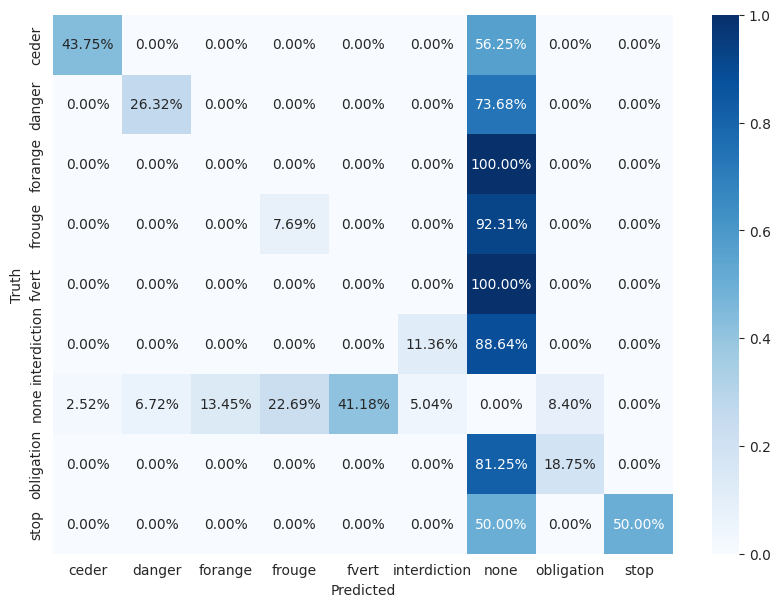

Precision:
 {'ceder': 0.945516458569807, 'danger': 0.7965194109772423, 'forange': 0.0, 'frouge': 0.2531914893617021, 'fvert': 0.0, 'interdiction': 0.6926658905704307, 'none': 0.0, 'obligation': 0.6905222437137329, 'stop': 1.0}

Recall:
 {'ceder': 0.4375, 'danger': 0.2631578947368421, 'forange': 0.0, 'frouge': 0.07692307692307693, 'fvert': 0.0, 'interdiction': 0.11363636363636363, 'none': 0.0, 'obligation': 0.1875, 'stop': 0.5}

Overall precision:
 0.17541303725514248

Overall recall:
 0.17541303725514248


In [14]:
# Initialize lists to store y (ground truth) and y_pred (predictions)
y = []
y_pred = []
matching_validation_row = []
fp_data = []

# Define IoU function
def iou(box1, box2):
    # Unpack the coordinates
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Calculate the intersection coordinates
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    # Calculate the intersection area
    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)

    # Calculate the areas of each box
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    # Calculate the union area
    union_area = box1_area + box2_area - inter_area

    # Calculate the IoU
    iou = inter_area / union_area

    return iou

# Match detections with ground truth
for _, detection_row in detections.iterrows():
    image_id_d, x_min_d, y_min_d, x_max_d, y_max_d, score_d, label_d = detection_row
    max_iou = 0.5
    matching_validation = 'none'

    for idx, validation_row in validations.iterrows():
        image_id_v, x_min_v, y_min_v, x_max_v, y_max_v, label_v = validation_row
        
        if image_id_v == image_id_d and label_v == label_d:
            iou_value = iou((x_min_v, y_min_v, x_max_v, y_max_v), (x_min_d, y_min_d, x_max_d, y_max_d))
            
            if iou_value > max_iou:
                max_iou = iou_value
                matching_validation = label_v
                
                matching_validation_row.append(idx)
    
    # Add ground truth and prediction based on maximum IoU
    y_pred.append(label_d)
    y.append(matching_validation)
    
    if matching_validation == 'none':
        fp_data.append(list(detection_row))

for idx, validation_row in validations.iterrows():
    image_id_v, x_min_v, y_min_v, x_max_v, y_max_v, label_v = validation_row
    if idx not in matching_validation_row:
        y.append(label_v)
        y_pred.append('none')

# Plot confusion matrix
cm = confusion_matrix(y, y_pred, normalize='true')
# Get unique labels
unique_labels = sorted(list(set(y)))

plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt=".2%",
    xticklabels=unique_labels,
    yticklabels=unique_labels,
    cmap="Blues",
)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

# Calculate precision and recall
precision = {}
recall = {}

for i in range(len(unique_labels)):
    cls = unique_labels[i]
    tp = cm[i, i]
    fp = np.sum(cm[:, i]) - tp
    fn = np.sum(cm[i, :]) - tp
    
    precision[cls] = tp / (tp + fp) if tp + fp > 0 else 0
    recall[cls] = tp / (tp + fn) if tp + fn > 0 else 0

print("Precision:\n", precision)
print("\nRecall:\n", recall)

tp_total = np.sum(np.diag(cm))
fp_total = np.sum(cm) - tp_total
fn_total = np.sum(cm) - tp_total

overall_precision = tp_total / (tp_total + fp_total) if tp_total + fp_total > 0 else 0
overall_recall = tp_total / (tp_total + fn_total) if tp_total + fn_total > 0 else 0

print("\nOverall precision:\n", overall_precision)
print("\nOverall recall:\n", overall_recall)


In [15]:
print(fp_data)

[['0297.jpg', 520.0, 400.0, 610.0, 600.0, 0.9194947608648661, 'fvert'], ['0297.jpg', 300.0, 320.0, 390.0, 520.0, 0.9172796257386443, 'fvert'], ['0810.jpg', 280.0, 680.0, 370.0, 880.0, 0.9772999953442412, 'fvert'], ['0810.jpg', 340.0, 520.0, 430.0, 720.0, 0.9212079487709047, 'fvert'], ['0419.jpg', 420.0, 0.0, 510.0, 200.0, 0.9836610330519826, 'fvert'], ['0419.jpg', 100.0, 280.0, 190.0, 480.0, 0.9763644024826471, 'fvert'], ['0419.jpg', 200.0, 40.0, 290.0, 240.0, 0.9709444285473677, 'forange'], ['0419.jpg', 480.0, 240.0, 570.0, 440.0, 0.9609610236707011, 'fvert'], ['0419.jpg', 360.0, 360.0, 496.0, 660.0, 0.9580471753704278, 'frouge'], ['0419.jpg', 200.0, 320.0, 290.0, 520.0, 0.9323649768339679, 'frouge'], ['0419.jpg', 0.0, 0.0, 90.0, 200.0, 0.9231160044272056, 'forange'], ['0733.jpg', 600.0, 240.0, 736.0, 540.0, 0.9704493357418088, 'fvert'], ['0733.jpg', 520.0, 440.0, 610.0, 640.0, 0.9603805718828561, 'forange'], ['0733.jpg', 240.0, 0.0, 330.0, 200.0, 0.9561117053703173, 'fvert'], ['0733.